In [2]:
import sys

sys.path.append('../../')

import random
import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

from sklearn import datasets
from dal_toolbox.models.resnet import train_one_epoch, evaluate
from dal_toolbox.models.ssl_train_methods.pimodel import train_one_epoch as pi_train_one_epoch
from dal_toolbox.models.ssl_train_methods.pseudolabel import train_one_epoch as pseudo_train_one_epoch

In [3]:
X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

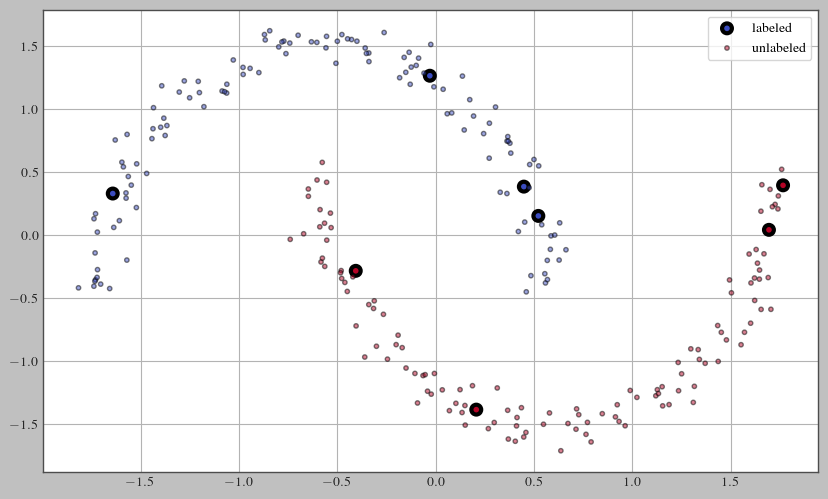

In [4]:
# Setup SSL 

class GaussianNoiseDataset(torch.utils.data.TensorDataset):
    def __init__(self, X, y, mean=0, std=1, noise=0.2):
        super(GaussianNoiseDataset, self).__init__(X, y)
        self.mean = mean
        self.std = std
        self.noise = noise
        assert noise >= 0 and noise <= 1, "noise is a probability and should be between 0 and 1"

    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)
        X = X + torch.randn_like(X)*self.noise
        return X, y

random.seed(2)
indices_class0 = [i for i in range(len(y)) if y[i] == 0]
indices_class1 = [i for i in range(len(y)) if y[i] == 1]
labeled_indices = random.sample(indices_class0, k=4) + random.sample(indices_class1, k=4)
unlabeled_indices = [i for i in range(X.shape[0]) if i not in labeled_indices]

X_labeled, y_labeled = X[labeled_indices], y[labeled_indices]
X_unlabeled, y_unlabeled = X[unlabeled_indices], y[unlabeled_indices]

labeled_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
unlabeled_ds = GaussianNoiseDataset(X_unlabeled, y_unlabeled, noise=0.0)

plt.figure(figsize=(10,6), facecolor='silver')
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=50, edgecolors='black', linewidths=3, label='labeled')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=10, alpha=0.5, label='unlabeled')
plt.legend()
plt.show()

In [5]:
class Net(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = 0, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

In [6]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=1)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

## Supervised Training

Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6993 (0.6993) acc1: 50.0000 (50.0000) time: 0.3333 data: 0.0004 max mem: 0
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6921 (0.6921) acc1: 50.0000 (50.0000) time: 0.0012 data: 0.0001 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6790 (0.6790) acc1: 50.0000 (50.0000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6619 (0.6619) acc1: 50.0000 (50.0000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6423 (0.6423) acc1: 50.0000 (50.0000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6214 (0.6214) acc1: 87.5000 (87.5000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [5] Total time: 0:00:00
Epoch [6] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6004 (0.6004) acc1: 87.5000 (87.5000) time: 0.00

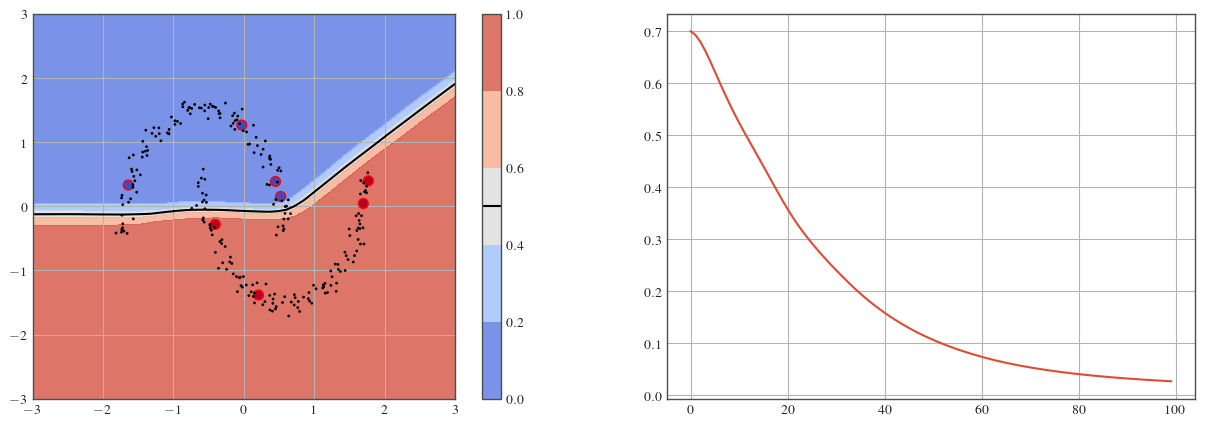

In [7]:
# Supervised model
torch.manual_seed(0)
n_epochs=100

supervised_optimizer_params = dict(lr=0.01, weight_decay=1e-4, momentum=.9)
supervised_model = Net(dropout_rate=0, num_classes=2)
supervised_optimizer = torch.optim.SGD(supervised_model.parameters(), **supervised_optimizer_params)
labeled_loader = DataLoader(labeled_ds, batch_size=8, shuffle=True)

criterion = nn.CrossEntropyLoss()

history = []
for i in range(n_epochs):
    train_stats = train_one_epoch(supervised_model, labeled_loader, criterion, supervised_optimizer, device='cuda', epoch=i)
    history.append(train_stats)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(supervised_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plt.show()

## Pseudo-Labeling

Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6993 (0.6993) sup_loss: 0.6993 (0.6993) unsup_loss: 0.0000 (0.0000) mask_ratio: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0021 data: 0.0002 max mem: 0
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6921 (0.6921) sup_loss: 0.6921 (0.6921) unsup_loss: 0.0000 (0.0000) mask_ratio: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0015 data: 0.0001 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6790 (0.6790) sup_loss: 0.6790 (0.6790) unsup_loss: 0.0000 (0.0000) mask_ratio: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0015 data: 0.0001 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6619 (0.6619) sup_loss: 0.6619 (0.6619) unsup_loss: 0.0000 (0.0000) mask_ratio: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0016 data: 0.0001 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6423 (0.6423) sup_loss

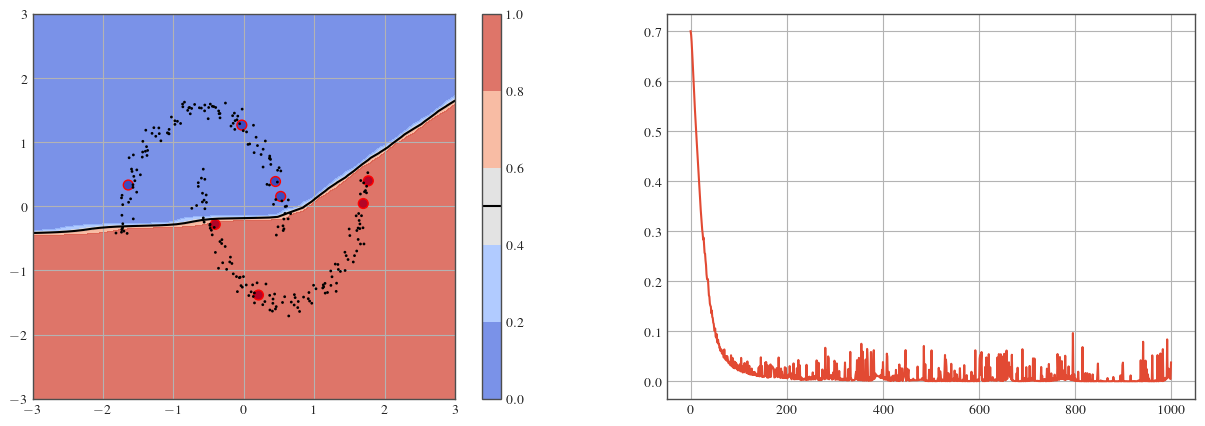

In [8]:
# Pseudolabels Model
torch.manual_seed(0)

n_epochs=1000

pseudo_optimizer_params = dict( lr=0.01, weight_decay=0.0001, momentum=.9,)
pseudo_model = Net(dropout_rate=0, num_classes=2)
pseudo_optimizer = torch.optim.SGD(pseudo_model.parameters(), **pseudo_optimizer_params)

unlabeled_ds = GaussianNoiseDataset(X_unlabeled, y_unlabeled, noise=0.1)
labeled_loader = DataLoader(labeled_ds, batch_size=8, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_ds, batch_size=8, shuffle=True)
dataloaders = {"train_sup": labeled_loader, "train_unsup": unlabeled_loader}

history = []
for i in range(n_epochs):
    train_stats = pseudo_train_one_epoch(
        model=pseudo_model, dataloaders=dataloaders, criterion=criterion, 
        optimizer=pseudo_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=10, use_hard_labels=False,
        n_epochs=n_epochs, p_cutoff=0.95)
    history.append(train_stats)

pseudo_model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(pseudo_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plt.show()

## Pi-Model

Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6993 (0.6993) sup_loss: 0.6993 (0.6993) unsup_loss: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0025 data: 0.0002 max mem: 0
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6921 (0.6921) sup_loss: 0.6921 (0.6921) unsup_loss: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0020 data: 0.0001 max mem: 1
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6790 (0.6790) sup_loss: 0.6790 (0.6790) unsup_loss: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0020 data: 0.0001 max mem: 1
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6619 (0.6619) sup_loss: 0.6619 (0.6619) unsup_loss: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0021 data: 0.0001 max mem: 1
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6423 (0.6423) sup_loss: 0.6423 (0.6423) unsup_loss: 0.0000 (0.0000) acc1: 50.0000 (50.0000) time: 0.0019 data: 0.0001 max mem: 1
Epoch

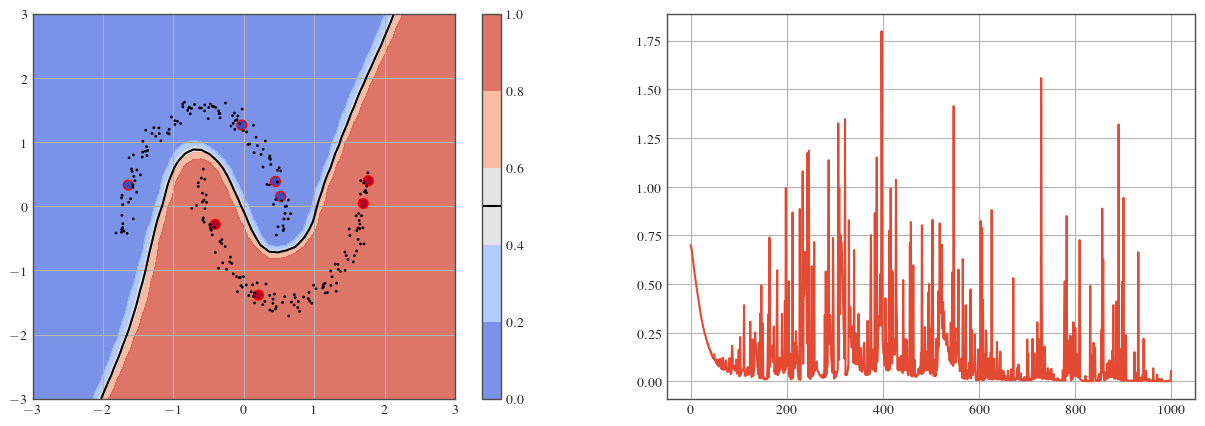

In [9]:
# Pimodel
torch.manual_seed(0)
n_epochs = 1000

pi_optimizer_params = dict(lr=0.01, weight_decay=0.0001, momentum=.9,)
pi_model = Net(dropout_rate=0, num_classes=2)
pi_optimizer = torch.optim.SGD(pi_model.parameters(), **pi_optimizer_params)

unlabeled_ds.noise = 0.1
labeled_loader = DataLoader(labeled_ds, batch_size=8, shuffle=True)
unlabeled_sampler1 = RandomSampler(unlabeled_ds, generator=torch.Generator().manual_seed(42))
unlabeled_sampler2 = RandomSampler(unlabeled_ds, generator=torch.Generator().manual_seed(42))
unlabeled_loader1 = DataLoader(unlabeled_ds, batch_size=8, sampler=unlabeled_sampler1)
unlabeled_loader2 = DataLoader(unlabeled_ds, batch_size=8, sampler=unlabeled_sampler2)
pi_loaders = {
        "train_sup": labeled_loader,
        "train_unsup_weak_1": unlabeled_loader1,
        "train_unsup_weak_2": unlabeled_loader2
    }

history = []
for i in range(n_epochs):
    train_stats = pi_train_one_epoch(
        model=pi_model, dataloaders=pi_loaders, criterion=criterion, 
        optimizer=pi_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=20,
        n_epochs=n_epochs)
    history.append(train_stats)

pi_model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(pi_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plt.show()

## Comparison

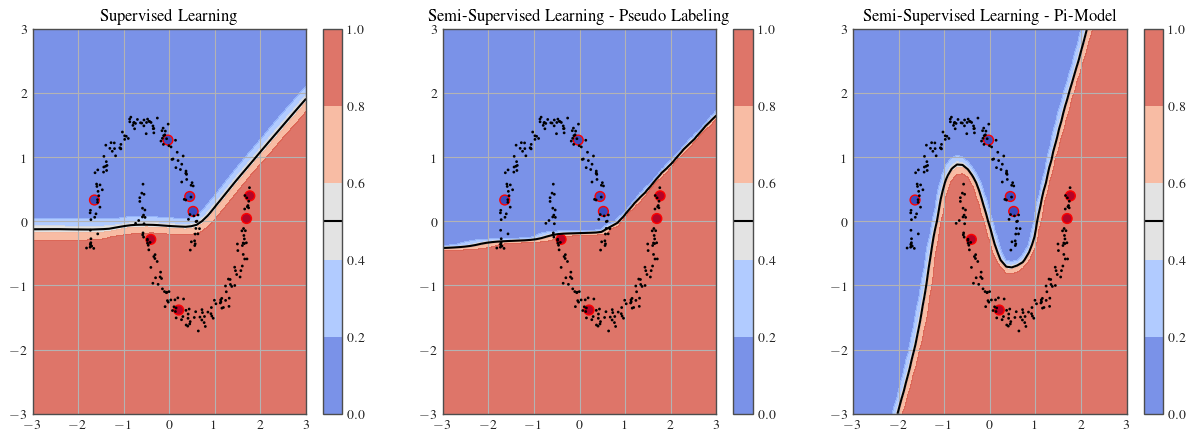

In [11]:
# Plot results
supervised_model.eval()
pseudo_model.eval()
pi_model.eval()

fig, axis = plt.subplots(1, 3, figsize=(15,5))
axis[0].set_title('Supervised Learning')
plot_contour(supervised_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0])
axis[1].set_title('Semi-Supervised Learning - Pseudo Labeling')
plot_contour(pseudo_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[1])
axis[2].set_title('Semi-Supervised Learning - Pi-Model')
plot_contour(pi_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[2])
plt.show()